$$
\begin{align*}
\text{minimize} ~~ & ~~
\sum_{i \in N} \left( \hat{w}_i^\mathrm{L} \varepsilon_i^\mathrm{L} + \hat{w}_i^\mathrm{U} \varepsilon_i^\mathrm{U} \right),
\\ \text{subject to} ~~ & ~~
a_{ij}^\mathrm{L+} w_j^\mathrm{U} - \varepsilon_i^\mathrm{L} \leq w_i^\mathrm{L} \leq a_{ij}^\mathrm{L-} w_j^\mathrm{U} + \varepsilon_i^\mathrm{L}, &&
i, j \in N, ~~ i \neq j, \\ & ~~
a_{ij}^\mathrm{U-} w_j^\mathrm{L} - \varepsilon_i^\mathrm{U} \leq w_i^\mathrm{U} \leq a_{ij}^\mathrm{U+} w_j^\mathrm{L} + \varepsilon_i^\mathrm{U}, &&
i, j \in N, ~~ i \neq j, \\ & ~~
\varepsilon_i^\mathrm{L} \geq w_i^\mathrm{L+} - w_i^\mathrm{L-}, ~~
\varepsilon_i^\mathrm{U} \geq w_i^\mathrm{U-} - w_i^\mathrm{U+}, &&
i \in N, \\ & ~~
w_i^\mathrm{L-} \leq a_{ij}^\mathrm{L-} w_j^\mathrm{U} , ~~
w_i^\mathrm{U-} \geq a_{ij}^\mathrm{U-} w_j^\mathrm{L}, &&
i, j \in N, ~~ i \neq j, \\ & ~~
w_i^\mathrm{L+} \geq a_{ij}^\mathrm{L+} w_j^\mathrm{U}, ~~
w_i^\mathrm{U+} \leq a_{ij}^\mathrm{U+} w_j^\mathrm{L}, &&
i, j \in N, ~~ i \neq j, \\ & ~~
\sum_{j \in N \backslash \{i\}} \left( w_j^\mathrm{U} \right) + w_i^\mathrm{L} \geq 1, ~~
\sum_{j \in N \backslash \{i\}} \left( w_j^\mathrm{L} \right) + w_i^\mathrm{U} \leq 1, &&
i \in N, \\ & ~~
\sum_{i \in N} \left( w_i^\mathrm{L} + w_i^\mathrm{U} \right) = 2,
\\ & ~~
w_i^\mathrm{U} \geq w_i^\mathrm{L} \geq \epsilon, ~~
w_i^\mathrm{L-}, w_i^\mathrm{U-}, w_i^\mathrm{L+}, w_i^\mathrm{U+} \geq \epsilon, ~~
\varepsilon_i^\mathrm{L}, \varepsilon_i^\mathrm{U} \geq 0, &&
i \in N. 
\end{align*}
$$

一度重みなしで計算すると, 中心の和が $1$ の区間ベクトル $W_i = \left( \left[ w_i^\mathrm{L}, w_i^\mathrm{U} \right] \right)$ が得られる.

$\hat{w}_i^\mathrm{L} = 1 / w_i^\mathrm{L}, \hat{w}_i^\mathrm{U} = 1 / w_i^\mathrm{U}, ~~ i \in N$ とする.

In [1]:
using IntervalArithmetic
using LaTeXStrings
using Latexify
using Statistics

include("./solution.jl")
include("./utils.jl")
include("./linear.jl")
include("./weightedLinear.jl")
include("./density_heatmap.jl")

include("../intervalPCM/index.jl")
include("../twofoldInterval/index.jl")
include("../twofoldIntervalPCM/index.jl")
include("../simulation.jl")

total (generic function with 1 method)

In [2]:
n = 5; simNum = 10000
print()

In [3]:
twofoldIntervalPCMs = map(
    case -> intervalPCM2TwofoldIntervalPCM(case.A₁, case.A₂),
    generateSimulationCases(n, simNum, 1))
crispPCMs = map(
    A -> twofoldIntervalPCM2CrispPCM(A),
    twofoldIntervalPCMs)
print()

In [4]:
rowGMs = map(
    matrices -> map(i -> geometric_mean(matrices.Āᶜ[i,:]), 1:n),
    crispPCMs
)
rowGMs = map(k -> map(i -> rowGMs[k][i] / sum(rowGMs[k]), 1:n), 1:simNum)
print()

In [5]:
weights = map(solution -> (
    wᴸ=inv.(solution.wᴸ),
    wᵁ=inv.(solution.wᵁ),
    ), map(
        A -> solveLinear(A),
        twofoldIntervalPCMs
    ))
print()

In [6]:
solutions = map(
    k -> solveWeightedLinear(
        twofoldIntervalPCMs[k],
        weights[k].wᴸ,
        weights[k].wᵁ),
    1:simNum
)
print()

In [32]:
GM = reduce(vcat, map(k -> map(i -> rowGMs[k][i], 1:n), 1:simNum))
ε = reduce(vcat,
    map(
        k -> map(
            i -> solutions[k].εᴸ[i] + solutions[k].εᵁ[i],
            1:n), 1:simNum))
wε = reduce(vcat,
    map(
        k -> map(
            i -> weights[k].wᴸ[i] * solutions[k].εᴸ[i] + weights[k].wᵁ[i] * solutions[k].εᵁ[i],
            1:n), 1:simNum))           
print()

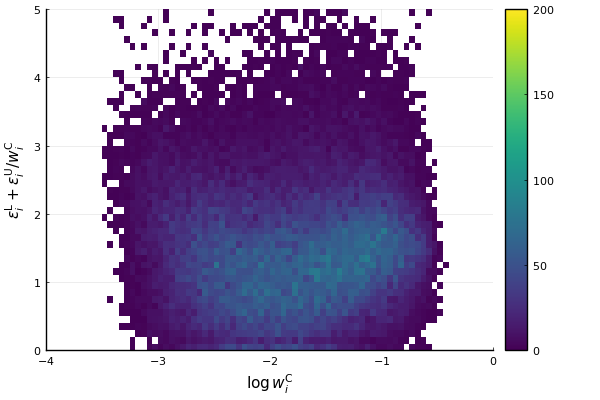

In [42]:
density_heatmap(log.(GM), map(k -> ε[k] / GM[k], 1:simNum*n),
    xlabel=L"\log w_i^\mathrm{C}",
    ylabel=L"\varepsilon_i^\mathrm{L} + \varepsilon_i^\mathrm{U} / w_i^\mathrm{C}",
    xbinsize=0.04,
    ybinsize=0.05,
    clims=(0.0, 200.0),
    xlims=(-4.0, 0.0),
    ylims=(0.0, 5.0),
    )

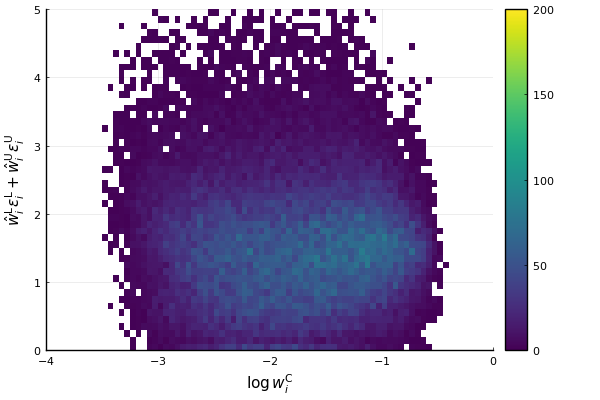

In [27]:
density_heatmap(log.(GM), wε,
    xlabel=L"\log w_i^\mathrm{C}",
    ylabel=L"\hat{w}_i^\mathrm{L} \varepsilon_i^\mathrm{L} + \hat{w}_i^\mathrm{U} \varepsilon_i^\mathrm{U}",
    xbinsize=0.04,
    ybinsize=0.05,
    clims=(0.0, 200.0),
    xlims=(-4.0, 0.0),
    ylims=(0.0, 5.0),
    )

In [24]:
cor(log.(GM), ε)

0.6886221613007389